基于U-Net的人像分割模型
 
本项目实现了一个基于U-Net架构的人像分割模型，用于从图像中提取人物前景。

In [1]:
# 安装必要的库
# !pip install beautifulsoup4 -t /home/aistudio/external-libraries --no-user
# !pip install albumentations -t /home/aistudio/external-libraries --no-user

In [2]:
# 导入所需的库
import os
import zipfile
import random
import json
import paddle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from paddle.io import Dataset, DataLoader
import cv2
import paddle.vision.transforms as T
import time
from tqdm.notebook import tqdm  # 使用notebook版本的tqdm
from visualdl import LogWriter
import paddle.nn as nn
import paddle.nn.functional as F
# import albumentations

# 确保paddle能够使用GPU (如果可用)
paddle.device.set_device('gpu:0' if paddle.device.is_compiled_with_cuda() else 'cpu')
print(f"使用设备: {paddle.device.get_device()}")


/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


使用设备: gpu:0


In [3]:
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False


In [4]:
# ## 数据准备
# 首先解压数据集到工作目录

# 创建工作目录并解压数据集
!mkdir -p /home/aistudio/work/matting_human_half # -p 确保递归创建父目录
!unzip -q data/data338285/matting_human_half.zip -d /home/aistudio/work/matting_human_half

# 检查解压后的文件结构
!ls -la /home/aistudio/work/matting_human_half

replace /home/aistudio/work/matting_human_half/clip_img/1803151818/clip_00000000/1803151818-00000003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
total 16
drwxr-xr-x   4 aistudio aistudio 4096 Jun  5 13:35 .
drwxr-xr-x   3 aistudio aistudio 4096 Jun  5 13:34 ..
drwxr-xr-x 150 aistudio aistudio 4096 Apr  7  2019 clip_img
drwxr-xr-x 150 aistudio aistudio 4096 Apr  7  2019 matting


In [5]:
# 数据集类定义
# 加载和预处理人像分割数据集
#   读取RGB图像和对应的Alpha遮罩
#   划分训练和验证集

class MattingHumanDataset(Dataset):
    def __init__(self, root_dir, is_train=True, transform=None, img_size=(256, 256)):
        """
        人像分割数据集类
        
        参数:
            root_dir (str): 数据集根目录
            is_train (bool): 是否为训练集
            transform: 数据预处理/增强方法
            img_size (tuple): 目标图像尺寸，默认(256, 256)
        """
        super(MattingHumanDataset, self).__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.is_train = is_train
        self.img_size = img_size
        self.image_paths = []
        self.mask_paths = []

        # 获取所有图像和掩码的路径
        self._collect_files()
        
        # 显示数据集文件夹结构
        print(f"数据集根目录: {root_dir}")
        print(f"图像文件夹: {os.path.join(root_dir, 'clip_img')}")
        print(f"掩码文件夹: {os.path.join(root_dir, 'matting')}")

        # 划分训练集和验证集
        if is_train:
            self.image_paths = self.image_paths[:int(len(self.image_paths) * 0.8)]
            self.mask_paths = self.mask_paths[:int(len(self.mask_paths) * 0.8)]
        else:
            self.image_paths = self.image_paths[int(len(self.image_paths) * 0.8):]
            self.mask_paths = self.mask_paths[int(len(self.mask_paths) * 0.8):]

        print(f"{'训练' if is_train else '验证'}数据集: {len(self.image_paths)} 图像")
        
        # 样本数为0时抛出异常
        if len(self.image_paths) == 0:
            print(f"数据集为空 root_dir={self.root_dir}, is_train={self.is_train}")
            raise ValueError("未找到任何样本，请检查数据集路径和结构！")

    # 收集图像和掩码的路径
    def _collect_files(self):
        # 图像所在文件夹路径
        img_root = os.path.join(self.root_dir, "clip_img")
        # 掩码所在文件夹路径
        mask_root = os.path.join(self.root_dir, "matting")

        # 检查目录是否存在
        if not os.path.exists(img_root):
            print(f"图像文件夹不存在: {img_root}")
        if not os.path.exists(mask_root):
            print(f"掩码文件夹不存在: {mask_root}")

        # 遍历所有编号文件夹
        for folder_id in os.listdir(img_root):
            # 一级子文件夹路径
            folder_path = os.path.join(img_root, folder_id)
            # 跳过不存在的目录，遍历文件夹时过滤无效路径
            if not os.path.isdir(folder_path):
                continue

            # 遍历所有clip_文件夹
            for clip_folder in os.listdir(folder_path):
                clip_path = os.path.join(folder_path, clip_folder)
                if not os.path.isdir(clip_path):
                    continue

                # 构建对应的matting文件夹名（将clip_替换为matting_）
                matting_folder = clip_folder.replace('clip_', 'matting_')
                # 对应的掩码文件夹路径
                mask_clip_path = os.path.join(mask_root, folder_id, matting_folder)
            
                if not os.path.exists(mask_clip_path):
                    print(f"掩码文件夹不存在: {mask_clip_path}")  # 可选：添加调试信息
                    continue

                # 遍历所有图像文件
                for img_file in os.listdir(clip_path):
                    if not img_file.endswith('.jpg'):
                        continue

                    img_path = os.path.join(clip_path, img_file)
                    # 掩码文件应该是同名但扩展名为png
                    mask_file = img_file.replace('.jpg', '.png')
                    mask_path = os.path.join(mask_clip_path, mask_file)

                    if os.path.exists(mask_path):
                        self.image_paths.append(img_path)
                        self.mask_paths.append(mask_path)

    # 返回数据集样本数量
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # 读取图像和掩码
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 读取PNG掩码图像，保留所有通道(包括Alpha通道)
        mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)

        # 提取Alpha通道
        if len(mask.shape) == 3 and mask.shape[2] == 4:  # RGBA格式
            # 提取Alpha通道
            alpha_mask = mask[:, :, 3]
        elif len(mask.shape) == 3:  # RGB格式，无Alpha通道
            # 转为灰度图
            alpha_mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
        else:  # 已经是灰度图
            alpha_mask = mask

        # 归一化 (0-255 -> 0-1)
        alpha_mask = alpha_mask.astype(np.float32) / 255.0

        # 数据增强
        if self.transform:
            augmented = self.transform(image=image, mask=alpha_mask)
            image = augmented['image']
            alpha_mask = augmented['mask']
        else:
            # 基本预处理
            image = cv2.resize(image, self.img_size)
            alpha_mask = cv2.resize(alpha_mask, self.img_size, interpolation=cv2.INTER_LINEAR)

            # 转换为适合PaddlePaddle的格式
            image = image.transpose(2, 0, 1).astype('float32') / 255.0
            alpha_mask = alpha_mask.astype('float32')
            alpha_mask = np.expand_dims(alpha_mask, axis=0)

        return paddle.to_tensor(image), paddle.to_tensor(alpha_mask)

In [6]:
train_transform = None
val_transform = None

数据集根目录: /home/aistudio/work/matting_human_half
图像文件夹: /home/aistudio/work/matting_human_half/clip_img
掩码文件夹: /home/aistudio/work/matting_human_half/matting
训练数据集: 27540 图像


[2025-06-05 20:20:48,568] [ WARNING] font_manager.py:1350 - findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
[2025-06-05 20:20:48,569] [ WARNING] font_manager.py:1355 - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


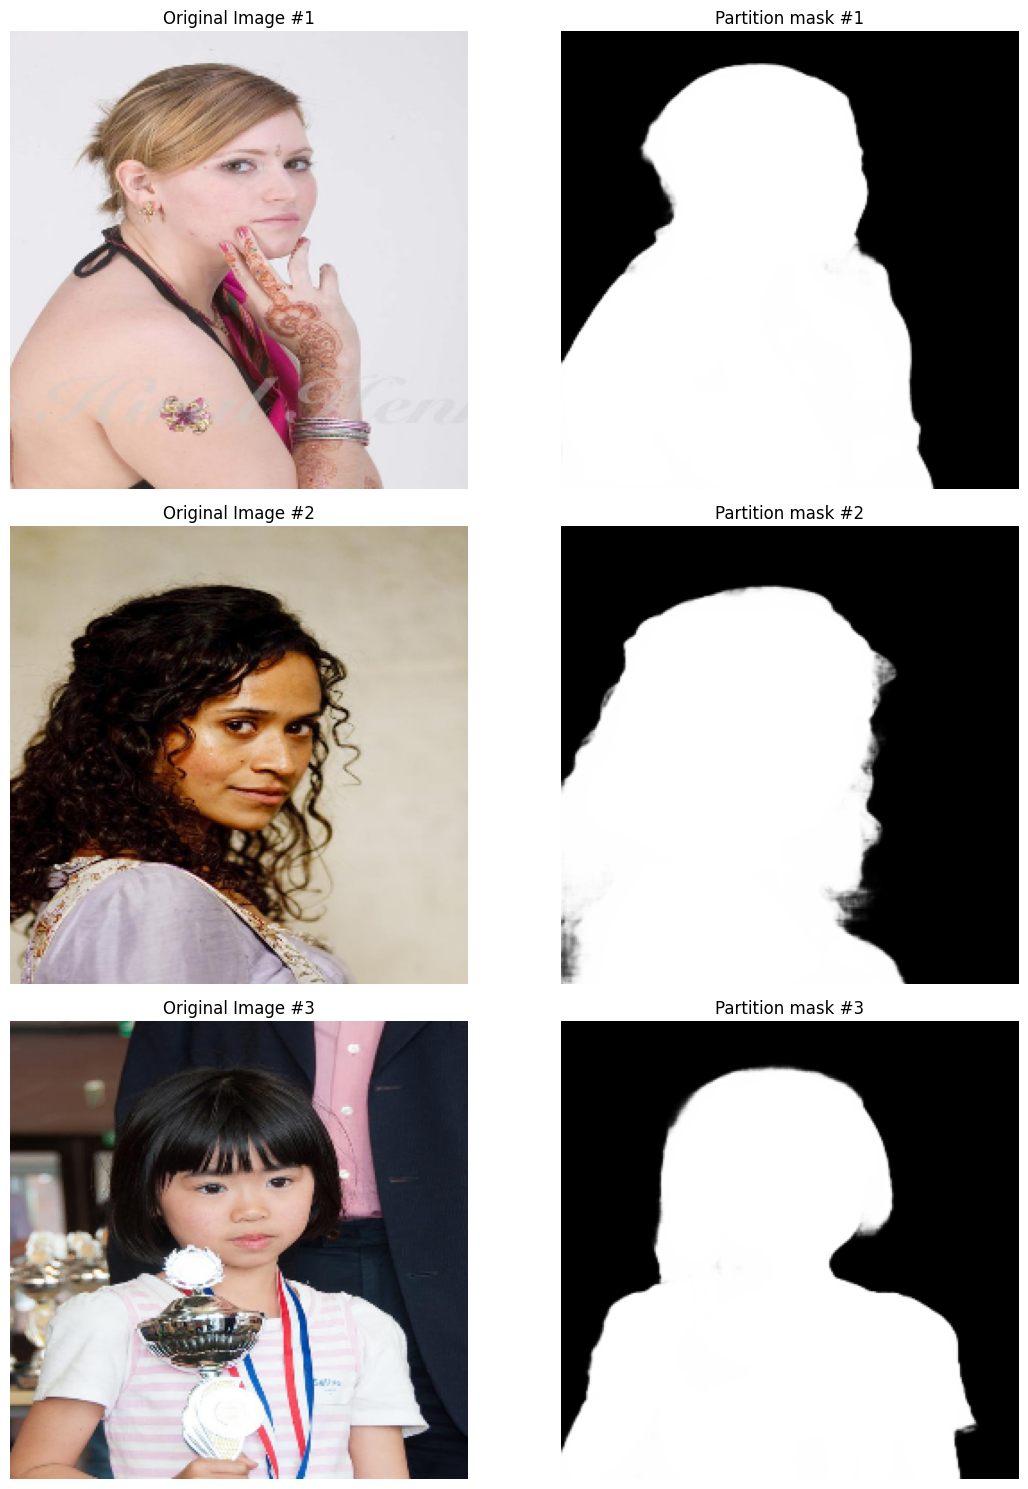

In [7]:
# 查看数据集样本
# 可视化几个训练样本，以确保数据加载正确

try:
    data_root = '/home/aistudio/work/matting_human_half'
    viz_dataset = MattingHumanDataset(
        root_dir=data_root,
        is_train=True,
        transform=None  # 不使用变换以便于可视化原始数据
    )
    
    # 显示几个样本
    fig, axs = plt.subplots(3, 2, figsize=(12, 15))
    
    for i in range(3):
        if i < len(viz_dataset):
            # 获取样本
            image, mask = viz_dataset[i]
            
            # 转换回numpy以便于显示
            image_np = image.numpy().transpose(1, 2, 0)
            mask_np = mask.numpy().squeeze()
            
            # 显示图像
            axs[i, 0].imshow(image_np)
            axs[i, 0].set_title(f"Original Image #{i+1}")
            axs[i, 0].axis('off')
            
            # 显示掩码
            axs[i, 1].imshow(mask_np, cmap='gray')
            axs[i, 1].set_title(f"Partition mask #{i+1}")
            axs[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"数据集可视化失败: {e}")


In [8]:
# U-Net模型定义

# U-Net的基本构建块：双重卷积
class DoubleConv(nn.Layer):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2D(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2D(out_channels),
            nn.ReLU(),
            nn.Conv2D(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2D(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.double_conv(x)

# U-Net模型
class UNet(nn.Layer):
    def __init__(self, n_channels=3, n_classes=1, bilinear=False):
        """
        U-Net分割模型
        
        参数:
            n_channels (int): 输入通道数
            n_classes (int): 输出通道数/类别数
            bilinear (bool): 是否使用双线性插值上采样
        """
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # 编码器路径（下采样）
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2D(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2D(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2D(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2D(2), DoubleConv(512, 1024))

        # 解码器路径（上采样）
        if bilinear:
            self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv_up1 = DoubleConv(1024 + 512, 512)

            self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv_up2 = DoubleConv(512 + 256, 256)

            self.up3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv_up3 = DoubleConv(256 + 128, 128)

            self.up4 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv_up4 = DoubleConv(128 + 64, 64)
        else:
            self.up1 = nn.Conv2DTranspose(1024, 512, kernel_size=2, stride=2)
            self.conv_up1 = DoubleConv(1024, 512)

            self.up2 = nn.Conv2DTranspose(512, 256, kernel_size=2, stride=2)
            self.conv_up2 = DoubleConv(512, 256)

            self.up3 = nn.Conv2DTranspose(256, 128, kernel_size=2, stride=2)
            self.conv_up3 = DoubleConv(256, 128)

            self.up4 = nn.Conv2DTranspose(128, 64, kernel_size=2, stride=2)
            self.conv_up4 = DoubleConv(128, 64)

        # 输出层
        self.outc = nn.Conv2D(64, n_classes, kernel_size=1)

    def forward(self, x):
        # 编码器路径
        x1 = self.inc(x)        # [B, 64, H, W]
        x2 = self.down1(x1)     # [B, 128, H/2, W/2]
        x3 = self.down2(x2)     # [B, 256, H/4, W/4]
        x4 = self.down3(x3)     # [B, 512, H/8, W/8]
        x5 = self.down4(x4)     # [B, 1024, H/16, W/16]

        # 解码器路径
        if self.bilinear:
            # 双线性插值上采样
            x = self.up1(x5)
            x = self.conv_up1(paddle.concat([x4, x], axis=1))

            x = self.up2(x)
            x = self.conv_up2(paddle.concat([x3, x], axis=1))

            x = self.up3(x)
            x = self.conv_up3(paddle.concat([x2, x], axis=1))

            x = self.up4(x)
            x = self.conv_up4(paddle.concat([x1, x], axis=1))
        else:
            # 转置卷积上采样
            x = self.up1(x5)
            # 处理特征图尺寸不匹配的情况
            diff_h = x4.shape[2] - x.shape[2]
            diff_w = x4.shape[3] - x.shape[3]

            # 如果尺寸不匹配，进行填充
            if diff_h > 0 or diff_w > 0:
                x = F.pad(x, [diff_w // 2, diff_w - diff_w // 2,
                              diff_h // 2, diff_h - diff_h // 2])

            x = self.conv_up1(paddle.concat([x4, x], axis=1))

            x = self.up2(x)
            diff_h = x3.shape[2] - x.shape[2]
            diff_w = x3.shape[3] - x.shape[3]
            if diff_h > 0 or diff_w > 0:
                x = F.pad(x, [diff_w // 2, diff_w - diff_w // 2,
                              diff_h // 2, diff_h - diff_h // 2])
            x = self.conv_up2(paddle.concat([x3, x], axis=1))

            x = self.up3(x)
            diff_h = x2.shape[2] - x.shape[2]
            diff_w = x2.shape[3] - x.shape[3]
            if diff_h > 0 or diff_w > 0:
                x = F.pad(x, [diff_w // 2, diff_w - diff_w // 2,
                              diff_h // 2, diff_h - diff_h // 2])
            x = self.conv_up3(paddle.concat([x2, x], axis=1))

            x = self.up4(x)
            diff_h = x1.shape[2] - x.shape[2]
            diff_w = x1.shape[3] - x.shape[3]
            if diff_h > 0 or diff_w > 0:
                x = F.pad(x, [diff_w // 2, diff_w - diff_w // 2,
                              diff_h // 2, diff_h - diff_h // 2])
            x = self.conv_up4(paddle.concat([x1, x], axis=1))

        # 输出层
        logits = self.outc(x)
        return logits


In [9]:
# 可视化模型架构
model = UNet(n_channels=3, n_classes=1)
print(f"模型参数总数: {sum(p.numel() for p in model.parameters())}")


模型参数总数: 31055297


W0605 20:20:49.282318    98 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W0605 20:20:49.283238    98 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.


In [10]:
# 损失函数定义
# 使用混合损失函数：BCE损失 + Dice损失，以获得更好的分割效果

# 定义Dice损失函数
def dice_loss(pred, target):
    """
    计算Dice损失（针对分割任务的特殊损失函数）
    1 - Dice系数，其中Dice系数 = 2*|X∩Y|/(|X|+|Y|)
    
    参数:
        pred: 预测掩码
        target: 真实掩码
    """
    smooth = 1.0
    pred = paddle.nn.functional.sigmoid(pred)
    intersection = paddle.sum(pred * target)
    union = paddle.sum(pred) + paddle.sum(target)
    dice_coef = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coef


In [11]:
# 模型训练函数
# 定义训练函数，使用Adam优化器和学习率调度器
def train_model(data_root, output_dir, batch_size=8, num_epochs=50, learning_rate=1e-4, img_size=(256, 256)):
    """
    训练U-Net分割模型
    
    参数:
        data_root: 数据集根目录
        output_dir: 输出目录，存放模型和日志
        batch_size: 批次大小
        num_epochs: 训练轮数 
        learning_rate: 学习率
        img_size: 图像尺寸
    
    返回:
        best_model_path: 最佳模型的路径
    """
    # 创建目录
    os.makedirs(output_dir, exist_ok=True)
    log_dir = os.path.join(output_dir, "logs")
    model_dir = os.path.join(output_dir, "models")
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

    # 日志记录器
    logger = LogWriter(logdir=log_dir)

    # 创建数据集
    train_dataset = MattingHumanDataset(
        root_dir=data_root,
        is_train=True,
        transform=train_transform,
        img_size=img_size
    )

    val_dataset = MattingHumanDataset(
        root_dir=data_root,
        is_train=False,
        transform=val_transform,
        img_size=img_size
    )

    # 训练集或验证集为空时直接报错
    if len(train_dataset) == 0:
        raise ValueError("训练集为空，请检查数据集路径和结构！")
    if len(val_dataset) == 0:
        raise ValueError("验证集为空，请检查数据集路径和结构！")

    # 数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # 初始化模型
    model = UNet(n_channels=3, n_classes=1)

    # 损失函数和优化器
    bce_criterion = nn.BCEWithLogitsLoss()
    optimizer = paddle.optimizer.Adam(parameters=model.parameters(), learning_rate=learning_rate)

    # 学习率衰减
    scheduler = paddle.optimizer.lr.ReduceOnPlateau(
        learning_rate=optimizer.get_lr(),
        factor=0.5,
        patience=3,
        verbose=True
    )
    optimizer.set_lr_scheduler(scheduler)

    # 训练循环
    best_val_loss = float('inf')
    start_time = time.time()
    
    # 记录训练历史
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': []
    }

    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        train_loss = 0
        train_bce_loss = 0
        train_dice_loss = 0

        # 替换tqdm进度条为简单的批次进度打印
        print(f'Epoch {epoch+1}/{num_epochs} [Train] - Processing {len(train_loader)} batches...')
        for batch_idx, (images, masks) in enumerate(train_loader):
            # 每10个batch打印一次进度
            if batch_idx % 10 == 0:
                print(f'  Batch {batch_idx+1}/{len(train_loader)}')
            
            # 前向传播
            outputs = model(images)

            # 混合损失：BCE + Dice
            bce = bce_criterion(outputs, masks)
            dice = dice_loss(outputs, masks)
            loss = bce + dice

            # 反向传播和优化
            loss.backward()
            optimizer.step()
            optimizer.clear_grad()

            # 更新损失
            train_loss += loss.item()
            train_bce_loss += bce.item()
            train_dice_loss += dice.item()

        # 验证阶段
        model.eval()
        val_loss = 0
        val_bce_loss = 0
        val_dice_loss = 0
        val_dice_coef = 0
        val_iou = 0

        # 批次进度打印
        print(f'Epoch {epoch+1}/{num_epochs} [Valid] - Processing {len(val_loader)} batches...')
        with paddle.no_grad():
            for batch_idx, (images, masks) in enumerate(val_loader):
                # 每10个batch打印一次进度
                if batch_idx % 10 == 0:
                    print(f'  Batch {batch_idx+1}/{len(val_loader)}')
                
                outputs = model(images)

                # 计算验证集损失
                bce = bce_criterion(outputs, masks)
                dice = dice_loss(outputs, masks)
                loss = bce + dice

                val_loss += loss.item()
                val_bce_loss += bce.item()
                val_dice_loss += dice.item()

                # 计算指标
                preds = paddle.nn.functional.sigmoid(outputs) > 0.5
                # 将布尔类型转换为浮点类型
                preds = preds.astype('float32')

                # Dice系数
                dice_coef = (2 * paddle.sum(preds * masks)) / (paddle.sum(preds) + paddle.sum(masks) + 1e-8)
                val_dice_coef += dice_coef.item()

                # IoU
                intersection = paddle.sum(preds * masks)
                union = paddle.sum(preds) + paddle.sum(masks) - intersection
                iou = intersection / (union + 1e-8)
                val_iou += iou.item()

        # 更新学习率
        scheduler.step(val_loss)
        optimizer.step()

        # 计算平均值
        train_loss /= len(train_loader)
        train_bce_loss /= len(train_loader)
        train_dice_loss /= len(train_loader)

        val_loss /= len(val_loader)
        val_bce_loss /= len(val_loader)
        val_dice_loss /= len(val_loader)
        val_dice_coef /= len(val_loader)
        val_iou /= len(val_loader)
        
        # 更新历史记录
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice_coef)
        history['val_iou'].append(val_iou)

        # 记录日志
        logger.add_scalar('训练/总损失', train_loss, epoch)
        logger.add_scalar('训练/BCE损失', train_bce_loss, epoch)
        logger.add_scalar('训练/Dice损失', train_dice_loss, epoch)

        logger.add_scalar('验证/总损失', val_loss, epoch)
        logger.add_scalar('验证/BCE损失', val_bce_loss, epoch)
        logger.add_scalar('验证/Dice损失', val_dice_loss, epoch)
        logger.add_scalar('验证/Dice系数', val_dice_coef, epoch)
        logger.add_scalar('验证/IoU', val_iou, epoch)

        # 打印训练进度
        print(f'\n===== Epoch {epoch + 1}/{num_epochs} =====')
        print(f'训练损失: {train_loss:.4f}, BCE: {train_bce_loss:.4f}, Dice: {train_dice_loss:.4f}')
        print(f'验证损失: {val_loss:.4f}, BCE: {val_bce_loss:.4f}, Dice: {val_dice_loss:.4f}')
        print(f'验证指标: Dice系数: {val_dice_coef:.4f}, IoU: {val_iou:.4f}')
        print(f'学习率: {optimizer.get_lr():.6f}')
        print(f'耗时: {time.time() - start_time:.2f}秒')
        print('=' * 30)

        # 保存模型
        epoch_model_path = os.path.join(model_dir, f'epoch_{epoch + 1}.pdparams')
        paddle.save(model.state_dict(), epoch_model_path)

        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(model_dir, 'best_model.pdparams')
            paddle.save(model.state_dict(), best_model_path)
            print(f'最佳模型已保存! 验证损失: {val_loss:.4f}')
    
    # 训练完成后可视化训练过程
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='train_loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='val_loss')
    plt.title('train_val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['val_dice'], 'g-')
    plt.title('Verify Dice coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice coefficient')
    
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['val_iou'], 'm-')
    plt.title('Verify IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_history.png'))
    plt.show()

    print('训练完成!')
    return os.path.join(model_dir, 'best_model.pdparams')


In [12]:
# 模型评估函数

def evaluate_model(model_path, data_root, batch_size=16):
    """
    评估训练好的模型
    
    参数:
        model_path: 模型权重文件路径
        data_root: 数据集根目录
        batch_size: 批次大小
    
    返回:
        mean_dice: 平均Dice系数
        mean_iou: 平均IoU
    """
    # 加载模型
    model = UNet(n_channels=3, n_classes=1)
    model.set_state_dict(paddle.load(model_path))
    model.eval()

    # 创建验证数据集
    test_dataset = MattingHumanDataset(
        root_dir=data_root,
        is_train=False,
        transform=val_transform
    )

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    dice_scores = []
    iou_scores = []

    print("开始评估...")
    print(f"评估 - Processing {len(test_loader)} batches...")
    with paddle.no_grad():
        for batch_idx, (images, masks) in enumerate(test_loader):
            # 每10个batch打印一次进度
            if batch_idx % 10 == 0:
                print(f'  Batch {batch_idx+1}/{len(test_loader)}')
            
            outputs = model(images)
            preds = paddle.nn.functional.sigmoid(outputs) > 0.5
            # 将布尔类型转换为浮点类型
            preds = preds.astype('float32')

            # 计算 Dice 系数
            dice = (2 * paddle.sum(preds * masks)) / (paddle.sum(preds) + paddle.sum(masks) + 1e-8)
            dice_scores.append(dice.item())

            # 计算 IoU
            intersection = paddle.sum(preds * masks)
            union = paddle.sum(preds) + paddle.sum(masks) - intersection
            iou = intersection / (union + 1e-8)
            iou_scores.append(iou.item())

    mean_dice = sum(dice_scores) / len(dice_scores)
    mean_iou = sum(iou_scores) / len(iou_scores)

    print(f'评估结果:')
    print(f'平均 Dice 系数: {mean_dice:.4f}')
    print(f'平均 IoU: {mean_iou:.4f}')
    
    # 可视化评估结果
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(dice_scores, bins=20, alpha=0.7)
    plt.axvline(mean_dice, color='r', linestyle='--', label=f'average value: {mean_dice:.4f}')
    plt.title('Dice coefficient distribution')
    plt.xlabel('Dice coefficient')
    plt.ylabel('Number of samples')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(iou_scores, bins=20, alpha=0.7)
    plt.axvline(mean_iou, color='r', linestyle='--', label=f'average value: {mean_iou:.4f}')
    plt.title('IoU distribution')
    plt.xlabel('IoU')
    plt.ylabel('Number of samples')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    return mean_dice, mean_iou


In [13]:
# 图片可视化函数

def visualize_results(model_path, test_image_path, output_path, img_size=(256, 256)):
    """
    可视化单张图片的分割结果
    
    参数:
        model_path: 模型权重文件路径
        test_image_path: 测试图像路径
        output_path: 输出图像保存路径
        img_size: 处理图像尺寸
    """
    # 加载模型
    model = UNet(n_channels=3, n_classes=1)
    model.set_state_dict(paddle.load(model_path))
    model.eval()

    # 读取和预处理图像
    image = cv2.imread(test_image_path)
    if image is None:
        print(f"无法读取图像: {test_image_path}")
        return
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 保存原图
    orig_img = image.copy()

    # 预处理为网络输入格式
    image = cv2.resize(image, img_size)
    processed_img = image.copy()

    image = image.transpose(2, 0, 1).astype('float32') / 255.0
    image = paddle.to_tensor(image).unsqueeze(0)

    # 预测
    with paddle.no_grad():
        output = model(image)
        pred = paddle.nn.functional.sigmoid(output) > 0.5

    # 将预测结果转换为图像
    pred_mask = pred.squeeze().numpy()
    pred_mask = (pred_mask * 255).astype(np.uint8)
    pred_mask = cv2.resize(pred_mask, (orig_img.shape[1], orig_img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 创建原图上的蒙版显示
    overlay = orig_img.copy()
    alpha = 0.4  # 透明度
    
    # 在原图上应用绿色半透明蒙版
    mask_colored = np.zeros_like(orig_img)
    mask_colored[pred_mask > 0] = [0, 255, 0]  # 绿色蒙版
    overlay = cv2.addWeighted(orig_img, 1-alpha, mask_colored, alpha, 0)
    
    # 创建分割边缘
    contours, _ = cv2.findContours(pred_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    edge_overlay = orig_img.copy()
    cv2.drawContours(edge_overlay, contours, -1, (0, 255, 0), 2)

    # 创建透明背景的人像（RGBA格式）
    portrait_only = np.zeros((orig_img.shape[0], orig_img.shape[1], 4), dtype=np.uint8)
    portrait_only[:, :, :3] = orig_img  # 复制RGB通道
    portrait_only[:, :, 3] = pred_mask  # Alpha通道使用分割掩码

    # 保存结果 - 1行5列布局
    plt.figure(figsize=(20, 4))

    plt.subplot(1, 5, 1)
    plt.imshow(orig_img)
    plt.title('image')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('mask')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(overlay)
    plt.title('Overlay results')
    plt.axis('off')
    
    plt.subplot(1, 5, 4)
    plt.imshow(edge_overlay)
    plt.title('Edge segmentation')
    plt.axis('off')
    
    plt.subplot(1, 5, 5)
    plt.imshow(portrait_only)
    plt.title('result')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()

    # 单独保存抠图结果（透明背景PNG）
    output_dir = os.path.dirname(output_path)
    portrait_rgba_path = os.path.join(output_dir, 'portrait_transparent.png')
    cv2.imwrite(portrait_rgba_path, cv2.cvtColor(portrait_only, cv2.COLOR_RGBA2BGRA))

    print(f'可视化结果已保存至 {output_path}')
    print(f'透明背景人像已保存至: {portrait_rgba_path}')

In [14]:
# 主函数：模型训练和评估

def run_unet_segmentation(data_root='./work/matting_human_half',
                          output_dir='./output',
                          batch_size=8,
                          num_epochs=10,
                          learning_rate=1e-4,
                          img_size=(256, 256),
                          mode='all',
                          model_path=None,
                          test_image=None):
    """
    运行人像分割U-Net模型的训练和测试
    
    参数:
        data_root (str): 数据集根目录
        output_dir (str): 输出目录
        batch_size (int): 批次大小
        num_epochs (int): 训练轮数
        learning_rate (float): 学习率
        img_size (tuple): 目标图像尺寸
        mode (str): 运行模式，可选 'train', 'evaluate', 'visualize', 'all'
        model_path (str): 模型路径(用于评估或可视化)
        test_image (str): 测试图像路径(用于可视化)
    """
    # 创建输出目录
    os.makedirs(output_dir, exist_ok=True)

    # 根据运行模式执行不同操作
    if mode in ['train', 'all']:
        print("\n" + "="*50)
        print("开始训练模型...")
        print("="*50)
        # 训练模型
        best_model_path = train_model(
            data_root=data_root,
            output_dir=output_dir,
            batch_size=batch_size,
            num_epochs=num_epochs,
            learning_rate=learning_rate,
            img_size=img_size
        )
    else:
        # 如果不训练，设置模型路径
        best_model_path = model_path or os.path.join(output_dir, 'models', 'best_model.pdparams')
        
        if not os.path.exists(best_model_path):
            print(f"警告: 模型文件 {best_model_path} 不存在!")
            if mode != 'train':
                return

    # 评估模型
    if mode in ['evaluate', 'all'] and os.path.exists(best_model_path):
        print("\n" + "="*50)
        print("开始评估模型...")
        print("="*50)
        mean_dice, mean_iou = evaluate_model(
            model_path=best_model_path,
            data_root=data_root,
            batch_size=batch_size
        )

        print(f"\n最终评估结果:")
        print(f"平均Dice系数: {mean_dice:.4f}")
        print(f"平均IoU: {mean_iou:.4f}")

    # 可视化结果
    if mode in ['visualize', 'all'] and test_image and os.path.exists(best_model_path):
        print("\n" + "="*50)
        print("生成可视化结果...")
        print("="*50)

        output_path = os.path.join(output_dir, 'visualization.png')
        visualize_results(
            model_path=best_model_path,
            test_image_path=test_image,
            output_path=output_path,
            img_size=img_size
        )
    elif mode in ['visualize', 'all'] and not test_image:
        print("\n警告: 未指定测试图像路径，跳过可视化步骤。")



开始训练模型...
数据集根目录: /home/aistudio/work/matting_human_half
图像文件夹: /home/aistudio/work/matting_human_half/clip_img
掩码文件夹: /home/aistudio/work/matting_human_half/matting
训练数据集: 27540 图像
数据集根目录: /home/aistudio/work/matting_human_half
图像文件夹: /home/aistudio/work/matting_human_half/clip_img
掩码文件夹: /home/aistudio/work/matting_human_half/matting
验证数据集: 6885 图像
Epoch 1/10 [Train] - Processing 1722 batches...
  Batch 1/1722


W0605 20:20:51.908407    98 gpu_resources.cc:306] WARNING: device: 0. The installed Paddle is compiled with CUDNN 8.9, but CUDNN version in your machine is 8.9, which may cause serious incompatible bug. Please recompile or reinstall Paddle with compatible CUDNN version.
/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/paddle/nn/layer/norm.py:818: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


  Batch 1391/1722
  Batch 1401/1722
  Batch 1411/1722
  Batch 1421/1722
  Batch 1431/1722
  Batch 1441/1722
  Batch 1451/1722
  Batch 1461/1722
  Batch 1471/1722
  Batch 1481/1722
  Batch 1491/1722
  Batch 1501/1722
  Batch 1511/1722
  Batch 1521/1722
  Batch 1531/1722
  Batch 1541/1722
  Batch 1551/1722
  Batch 1561/1722
  Batch 1571/1722
  Batch 1581/1722
  Batch 1591/1722
  Batch 1601/1722
  Batch 1611/1722
  Batch 1621/1722
  Batch 1631/1722
  Batch 1641/1722
  Batch 1651/1722
  Batch 1661/1722
  Batch 1671/1722
  Batch 1681/1722
  Batch 1691/1722
  Batch 1701/1722
  Batch 1711/1722
  Batch 1721/1722
Epoch 6/10 [Valid] - Processing 431 batches...
  Batch 1/431
  Batch 11/431
  Batch 21/431
  Batch 31/431
  Batch 41/431
  Batch 51/431
  Batch 61/431
  Batch 71/431
  Batch 81/431
  Batch 91/431
  Batch 101/431
  Batch 111/431
  Batch 121/431
  Batch 131/431
  Batch 141/431
  Batch 151/431
  Batch 161/431
  Batch 171/431
  Batch 181/431
  Batch 191/431
  Batch 201/431
  Batch 211/431


[2025-06-06 00:55:23,308] [ WARNING] font_manager.py:1350 - findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
[2025-06-06 00:55:23,310] [ WARNING] font_manager.py:1355 - findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


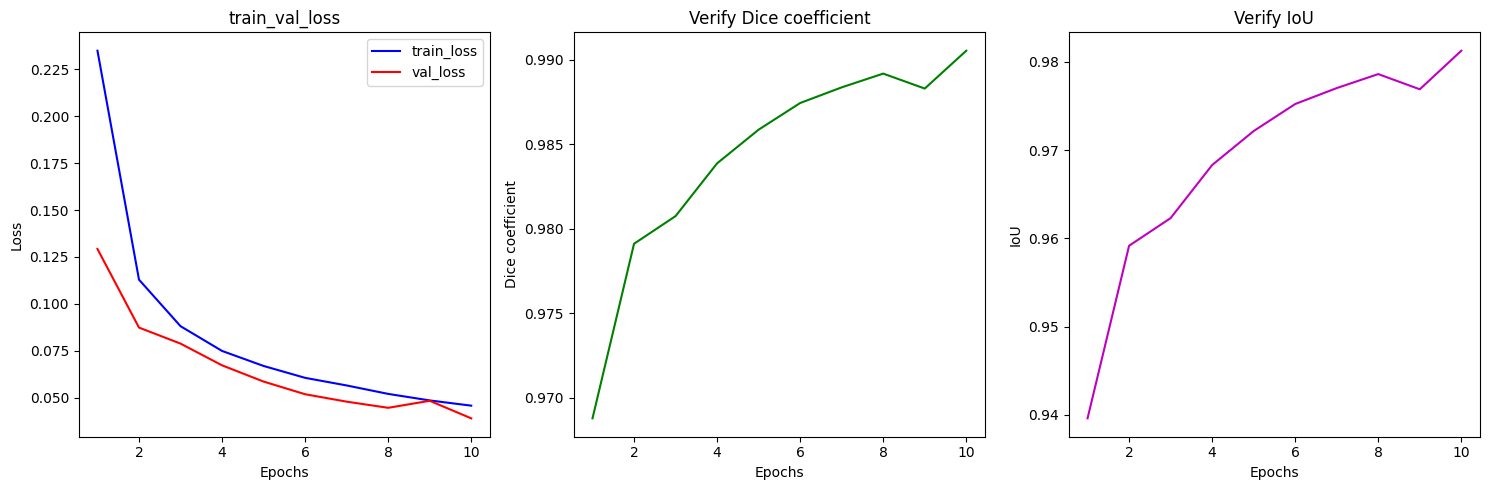

训练完成!

开始评估模型...
数据集根目录: /home/aistudio/work/matting_human_half
图像文件夹: /home/aistudio/work/matting_human_half/clip_img
掩码文件夹: /home/aistudio/work/matting_human_half/matting
验证数据集: 6885 图像
开始评估...
评估 - Processing 431 batches...
  Batch 1/431
  Batch 11/431
  Batch 21/431
  Batch 31/431
  Batch 41/431
  Batch 51/431
  Batch 61/431
  Batch 71/431
  Batch 81/431
  Batch 91/431
  Batch 101/431
  Batch 111/431
  Batch 121/431
  Batch 131/431
  Batch 141/431
  Batch 151/431
  Batch 161/431
  Batch 171/431
  Batch 181/431
  Batch 191/431
  Batch 201/431
  Batch 211/431
  Batch 221/431
  Batch 231/431
  Batch 241/431
  Batch 251/431
  Batch 261/431
  Batch 271/431
  Batch 281/431
  Batch 291/431
  Batch 301/431
  Batch 311/431
  Batch 321/431
  Batch 331/431
  Batch 341/431
  Batch 351/431
  Batch 361/431
  Batch 371/431
  Batch 381/431
  Batch 391/431
  Batch 401/431
  Batch 411/431
  Batch 421/431
  Batch 431/431
评估结果:
平均 Dice 系数: 0.9834
平均 IoU: 0.9675


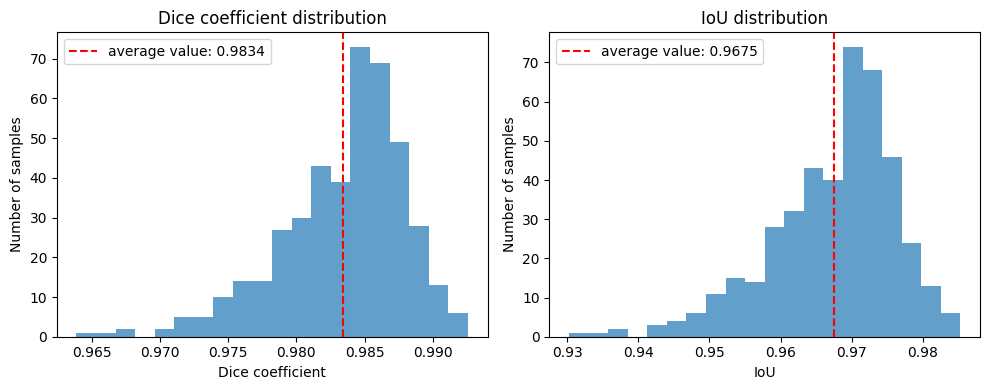


最终评估结果:
平均Dice系数: 0.9834
平均IoU: 0.9675

生成可视化结果...
无法读取图像: /home/aistudio/work/matting_human_half/test.jpg


[ WARN:0@17109.121] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/home/aistudio/work/matting_human_half/test.jpg'): can't open/read file: check file path/integrity


In [15]:
# 开始训练和评估模型
# 设置配置参数并运行模型

# 设置参数
config = {
    # 数据路径
    'data_root': '/home/aistudio/work/matting_human_half',
    'output_dir': './output',

    # 训练参数
    'batch_size': 16,  # 减小批次大小以适应更大的图像
    'num_epochs': 10,
    'learning_rate': 1e-4,
    'img_size': (512, 384),  # 保持原始宽高比的较大尺寸

    # 运行模式
    'mode': 'all',
    'model_path': None,
    'test_image': '/home/aistudio/work/matting_human_half/test.jpg'
}

# 运行模型训练和测试
run_unet_segmentation(**config)


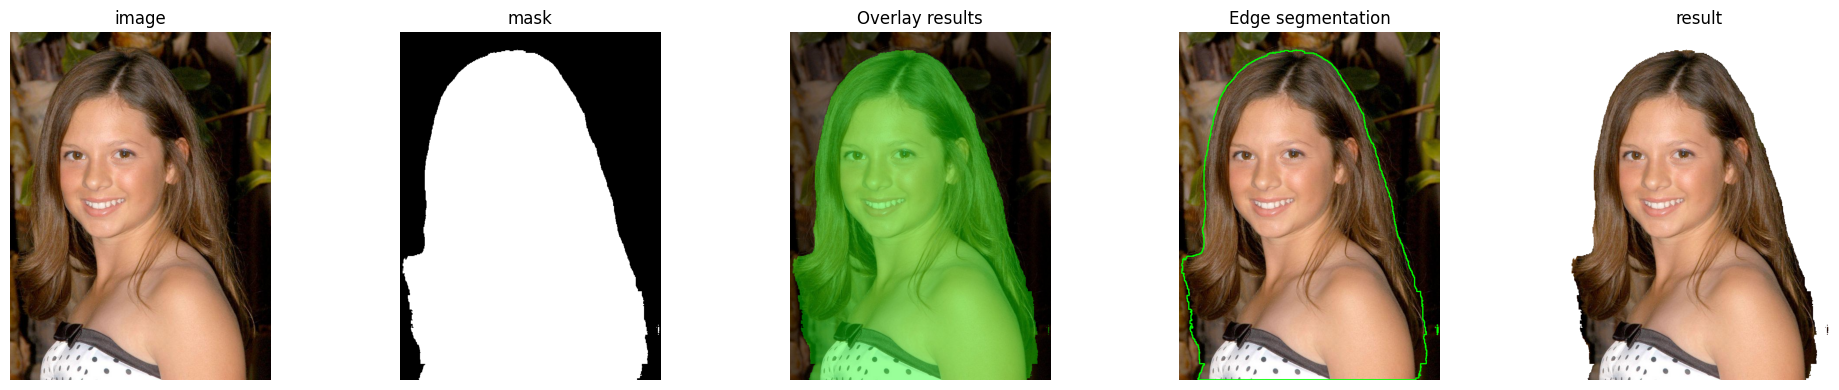

可视化结果已保存至 ./output/visualization2.png
透明背景人像已保存至: ./output/portrait_transparent.png


In [17]:
# 独立调用模型对结果的可视化测试
output_path = os.path.join('./output', 'visualization2.png')
visualize_results(
    model_path='./output/models/best_model.pdparams',
    test_image_path='./work/matting_human_half/test.jpg',
    output_path=output_path,
    img_size=(512,384)
)